In [1]:
!nvidia-smi

Thu Aug 11 17:23:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install pretrainedmodels
!pip install efficientnet_pytorch
!pip install timm

In [ ]:
!pip install opencv-python-headless==4.1.2.30

In [ ]:
!pip install PyYAML==5.3.1

In [ ]:
!pip list

In [ ]:
!git clone https://github.com/qubvel/segmentation_models.pytorch

In [6]:
%cd /content/segmentation_models.pytorch

/content/segmentation_models.pytorch


In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [9]:
# from google.colab import drive #インポート
# drive.mount('/content/gdrive') #GoogleDriveのマウント

Mounted at /content/gdrive


In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# segモデルの推論

In [11]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

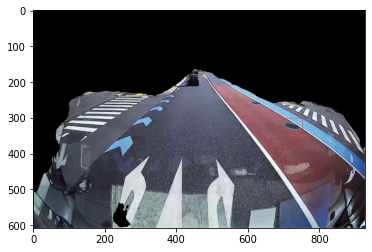

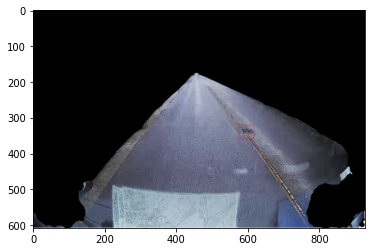

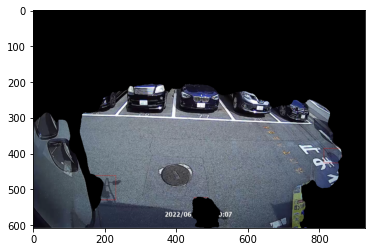

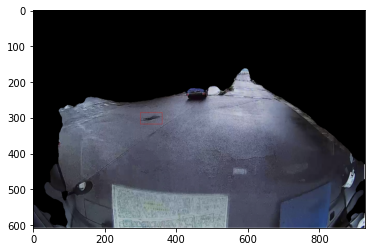

[<PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCA9349D0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCC0527D0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCA6D7A90>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCA6BEDD0>]


In [12]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image

img_paths = ["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png"]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
  plt.figure()
  plt.imshow(view_image)
  plt.show()

print(to_yolo_imagePIL)

APIに代替するコードはここから

In [13]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
# modelは、setting.py変数化
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'
img_paths = ["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png"]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image
# 75行目から83行目のinput_listをimg_pilsに変更するとそのまま運用可能

img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
print(to_yolo_imagePIL)

[<PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCA567790>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCA567E50>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCA567910>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F6CCA567A90>]


In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/code/static/model/asahuka96hozon.pt')
YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/holeplus.pt')
YOLO_MODEL.to(device)
YOLO_MODEL.conf = 0.25  # NMS confidence threshold
YOLO_MODEL.iou = 0.45  # NMS IoU threshold
YOLO_MODEL.agnostic = False  # NMS class-agnostic
YOLO_MODEL.multi_label = False  # NMS multiple labels per box
YOLO_MODEL.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
YOLO_MODEL.max_det = 1000  # maximum number of detections per image
YOLO_MODEL.amp = False  # Automatic Mixed Precision (AMP) inference
model = YOLO_MODEL
print("YOLOv5 🚀 torch 1.10.2+cu102")
input_list = to_yolo_imagePIL

results = model(input_list, size=640)
num = len(input_list)
out_result = {}
out_result["output_"] = []
for k in range(num):
    result = results.pandas().xyxy[k]
    result = result[result["class"]==0]
    out_result["output_"].append(result.to_json(orient="records"))

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
INFO:yolov5:requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
requirements: PyYAML>=5.3.1 not found and is required by Y

YOLOv5 🚀 torch 1.10.2+cu102


In [15]:
out_result["output_"]

['[]',
 '[{"xmin":570.1845703125,"ymin":320.2659301758,"xmax":622.3637695312,"ymax":358.7599182129,"confidence":0.8314717412,"class":0,"name":"hole"}]',
 '[]',
 '[]']

0
1
2
3


<Figure size 432x288 with 0 Axes>

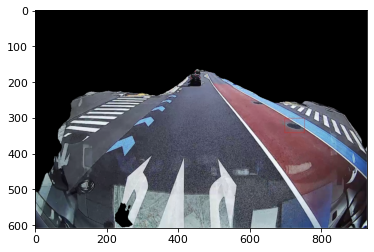

<Figure size 432x288 with 0 Axes>

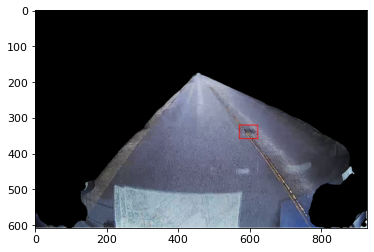

<Figure size 432x288 with 0 Axes>

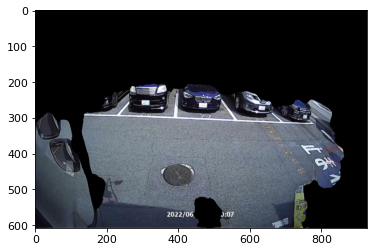

<Figure size 432x288 with 0 Axes>

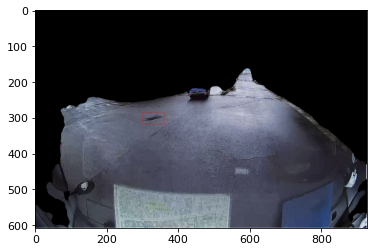

In [16]:
import ast
for enunum, _ in enumerate(out_result["output_"]):
  print(enunum)
  img_pil = to_yolo_imagePIL[enunum]
  for bbox in ast.literal_eval(_):
    draw = ImageDraw.Draw(img_pil)
    # pillowの四角形表示は、枠線を調節する変数はない。
    draw.rectangle((bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]), fill=None, outline=(255, 0, 0))
    draw.rectangle((bbox["xmin"]+1, bbox["ymin"]+1, bbox["xmax"]+1, bbox["ymax"]+1), fill=None, outline=(255, 0, 0))
  plt.figure()
  plt.figure()
  plt.imshow(img_pil)
  plt.show()

# 未知物体検出モデル

In [73]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

In [218]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
# modelは、setting.py変数化
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'
img_paths = ["/content/toOOD1.jpg", "/content/toOOD2.jpg", "/content/toOOD3.jpg", "/content/toOOD4.jpg", "/content/toOOD5.png", 
             "/content/toOOD6.png","/content/toOOD7.png",]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((32*19, 32*29))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image
# 75行目から83行目のinput_listをimg_pilsに変更するとそのまま運用可能

img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((32*19, 32*29))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
# to_yolo_imagePIL = img_pils
print(to_yolo_imagePIL)

[<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EB6E2D0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EB6E9D0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EB6E1D0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EB6E210>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EB6EA90>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6D326BD0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6D326B90>]


In [211]:
# !git clone https://github.com/ultralytics/yolov5.git

In [253]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/code/static/model/asahuka96hozon.pt')
YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/OOD_v1_100clust.pt')
YOLO_MODEL.to(device)
YOLO_MODEL.conf = 0.1  # NMS confidence threshold
YOLO_MODEL.iou = 0.1  # NMS IoU threshold
YOLO_MODEL.agnostic = True  # NMS class-agnostic
YOLO_MODEL.multi_label = False  # NMS multiple labels per box
YOLO_MODEL.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
YOLO_MODEL.max_det = 1000  # maximum number of detections per image
YOLO_MODEL.amp = False  # Automatic Mixed Precision (AMP) inference
# YOLO_MODEL.single_cls = True
# YOLO_MODEL.agnostic_nms = True

model = YOLO_MODEL
print("YOLOv5 🚀 torch 1.10.2+cu102")
input_list = to_yolo_imagePIL

results = model(input_list, size=640*2)
num = len(input_list)
out_result = {}
out_result["output_"] = []
for k in range(num):
    result = results.pandas().xyxy[k]
    result["class"]=0
    result["name"]="object"
    # result = result[result["class"]==0]
    out_result["output_"].append(result.to_json(orient="records"))

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
INFO:yolov5:YOLOv5 🚀 2022-8-11 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 2022-8-11 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 213 layers, 7279825 parameters, 0 gradients
Model summary: 213 layers, 7279825 parameters, 0 gradients
INFO:yolov5:Adding AutoShape... 
Adding AutoShape... 


YOLOv5 🚀 torch 1.10.2+cu102


In [254]:
out_result["output_"]

['[{"xmin":468.0370483398,"ymin":0.0,"xmax":927.4993286133,"ymax":429.5149841309,"confidence":0.1103690416,"class":0,"name":"object"},{"xmin":3.7849431038,"ymin":0.6079214811,"xmax":465.8856811523,"ymax":470.5443115234,"confidence":0.101661548,"class":0,"name":"object"}]',
 '[{"xmin":596.9375610352,"ymin":459.0162963867,"xmax":773.5855102539,"ymax":558.9169311523,"confidence":0.3621517718,"class":0,"name":"object"},{"xmin":189.7832794189,"ymin":445.0188293457,"xmax":394.3058166504,"ymax":538.4896240234,"confidence":0.1318718642,"class":0,"name":"object"}]',
 '[{"xmin":163.0425872803,"ymin":469.66015625,"xmax":441.1939086914,"ymax":545.0740356445,"confidence":0.6563116312,"class":0,"name":"object"}]',
 '[{"xmin":269.2808837891,"ymin":371.6824035645,"xmax":342.1041870117,"ymax":411.7086486816,"confidence":0.1732388288,"class":0,"name":"object"},{"xmin":647.4732666016,"ymin":256.8103027344,"xmax":800.0125732422,"ymax":403.9143676758,"confidence":0.1674000472,"class":0,"name":"object"},{"x

0
<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6E7019D0>


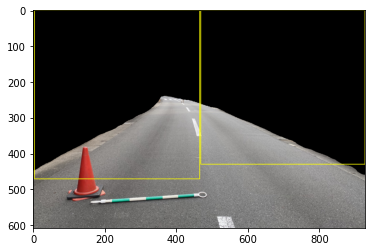

1
<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6E93BFD0>


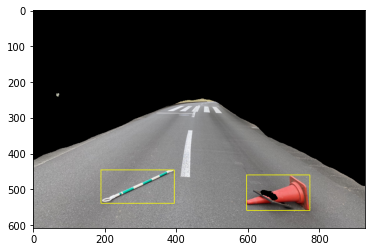

2
<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6D44F0D0>


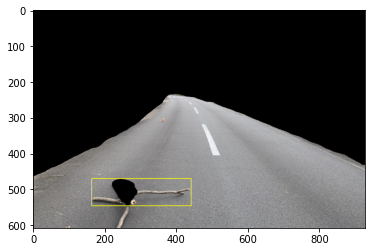

3
<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EC77BD0>


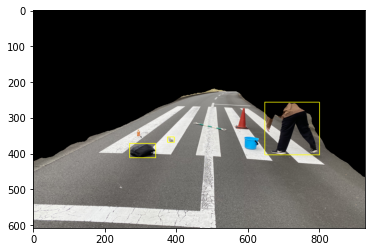

4
<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EE11210>


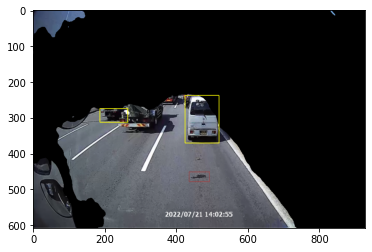

5
<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6E397110>


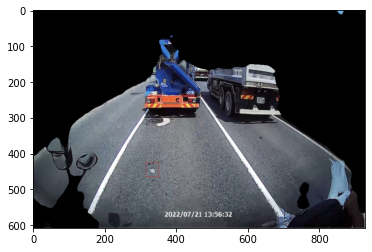

6
<PIL.Image.Image image mode=RGB size=928x608 at 0x7F9A6EA34D90>


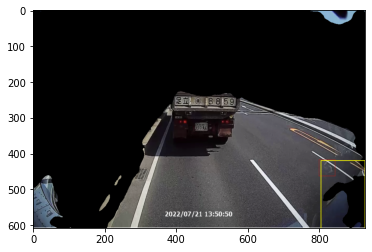

In [255]:
%matplotlib inline
import ast
import copy
for enunum, _ in enumerate(out_result["output_"]):
  print(enunum)
  img_pil = copy.deepcopy(to_yolo_imagePIL[enunum])
  print(img_pil)
  for bbox in ast.literal_eval(_):
    draw = ImageDraw.Draw(img_pil)
    draw.rectangle((bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]), fill=None, outline=(255, 255, 0))
    draw.rectangle((bbox["xmin"]+1, bbox["ymin"]+1, bbox["xmax"]+1, bbox["ymax"]+1), fill=None, outline=(255, 255, 0))
  plt.figure()
  plt.imshow(img_pil)
  plt.show()
  plt.close()

In [256]:
# 🌟 既知物体の排除機構

# 検出された物体のpillow型の画像リスト作成
object_images_list = []
for i in range(len(out_result["output_"])):
  for i_bbox in eval(out_result["output_"][i]):
    print(i_bbox)
    i_bbox_image = input_list[i].crop((i_bbox["xmin"], i_bbox["ymin"], i_bbox["xmax"], i_bbox["ymax"]))
    object_images_list.append(i_bbox_image)

# 学習済みモデルで検出された物体画像から、取り除き対象のみ結果として保持
YOLO_TO_REMOVE = torch.hub.load('ultralytics/yolov5', 'yolov5m')
YOLO_TO_REMOVE.to(device)
YOLO_TO_REMOVE.conf = 0.4  # NMS confidence threshold
YOLO_TO_REMOVE.iou = 0.4  # NMS IoU threshold
results_to_remove = YOLO_TO_REMOVE(object_images_list, size=300)
print(results_to_remove)

objects_out_result = []
num_to_remove = len(object_images_list)
for k in range(num_to_remove):
    result_to_remove = results_to_remove.pandas().xyxy[k]
    result_to_remove = result_to_remove[
        (
            (result_to_remove["name"]=="bicycle")|
            (result_to_remove["name"]=="car")| 
            (result_to_remove["name"]=="person")|
            (result_to_remove["name"]=="bus")|
            (result_to_remove["name"]=="truck")
        )
    ]
    objects_out_result.append(result_to_remove.to_json(orient="records"))

# objectの名称が取り除き対象ではない時、returnするリストに追加
out_result_after_remove = [[] for i in range(len(out_result["output_"]))]
object_number = -1
for i in range(len(out_result["output_"])):
  for i_bbox in eval(out_result["output_"][i]):
    object_number +=1
    if len(objects_out_result[object_number])==2:
      out_result_after_remove[i].append(i_bbox)
    else:
      print("物体が排除されました")

# josn形式に変更
for i in range(len(out_result_after_remove)):
  out_result_after_remove[i] = str(out_result_after_remove[i])
out_result_after_remove

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
INFO:yolov5:YOLOv5 🚀 2022-8-11 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 2022-8-11 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



{'xmin': 468.0370483398, 'ymin': 0.0, 'xmax': 927.4993286133, 'ymax': 429.5149841309, 'confidence': 0.1103690416, 'class': 0, 'name': 'object'}
{'xmin': 3.7849431038, 'ymin': 0.6079214811, 'xmax': 465.8856811523, 'ymax': 470.5443115234, 'confidence': 0.101661548, 'class': 0, 'name': 'object'}
{'xmin': 596.9375610352, 'ymin': 459.0162963867, 'xmax': 773.5855102539, 'ymax': 558.9169311523, 'confidence': 0.3621517718, 'class': 0, 'name': 'object'}
{'xmin': 189.7832794189, 'ymin': 445.0188293457, 'xmax': 394.3058166504, 'ymax': 538.4896240234, 'confidence': 0.1318718642, 'class': 0, 'name': 'object'}
{'xmin': 163.0425872803, 'ymin': 469.66015625, 'xmax': 441.1939086914, 'ymax': 545.0740356445, 'confidence': 0.6563116312, 'class': 0, 'name': 'object'}
{'xmin': 269.2808837891, 'ymin': 371.6824035645, 'xmax': 342.1041870117, 'ymax': 411.7086486816, 'confidence': 0.1732388288, 'class': 0, 'name': 'object'}
{'xmin': 647.4732666016, 'ymin': 256.8103027344, 'xmax': 800.0125732422, 'ymax': 403.914

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
INFO:yolov5:Adding AutoShape... 
Adding AutoShape... 


image 1/11: 430x459 (no detections)
image 2/11: 470x462 (no detections)
image 3/11: 100x177 (no detections)
image 4/11: 93x204 1 baseball bat
image 5/11: 75x278 (no detections)
image 6/11: 40x73 (no detections)
image 7/11: 147x153 1 person
image 8/11: 15x18 (no detections)
image 9/11: 134x94 1 bus, 1 truck
image 10/11: 38x77 (no detections)
image 11/11: 188x123 1 person
Speed: 0.9ms pre-process, 6.4ms inference, 0.6ms NMS per image at shape (11, 3, 320, 320)

物体が排除されました
物体が排除されました
物体が排除されました


["[{'xmin': 468.0370483398, 'ymin': 0.0, 'xmax': 927.4993286133, 'ymax': 429.5149841309, 'confidence': 0.1103690416, 'class': 0, 'name': 'object'}, {'xmin': 3.7849431038, 'ymin': 0.6079214811, 'xmax': 465.8856811523, 'ymax': 470.5443115234, 'confidence': 0.101661548, 'class': 0, 'name': 'object'}]",
 "[{'xmin': 596.9375610352, 'ymin': 459.0162963867, 'xmax': 773.5855102539, 'ymax': 558.9169311523, 'confidence': 0.3621517718, 'class': 0, 'name': 'object'}, {'xmin': 189.7832794189, 'ymin': 445.0188293457, 'xmax': 394.3058166504, 'ymax': 538.4896240234, 'confidence': 0.1318718642, 'class': 0, 'name': 'object'}]",
 "[{'xmin': 163.0425872803, 'ymin': 469.66015625, 'xmax': 441.1939086914, 'ymax': 545.0740356445, 'confidence': 0.6563116312, 'class': 0, 'name': 'object'}]",
 "[{'xmin': 269.2808837891, 'ymin': 371.6824035645, 'xmax': 342.1041870117, 'ymax': 411.7086486816, 'confidence': 0.1732388288, 'class': 0, 'name': 'object'}, {'xmin': 375.8945922852, 'ymin': 353.2279968262, 'xmax': 394.140

0


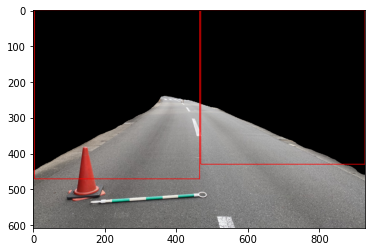

1


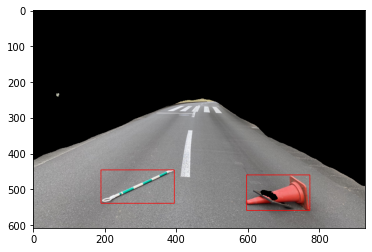

2


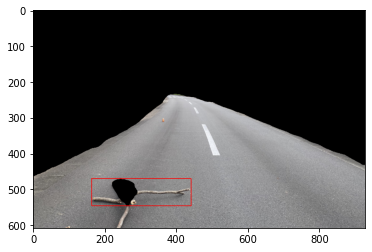

3


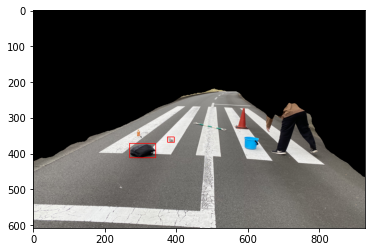

4


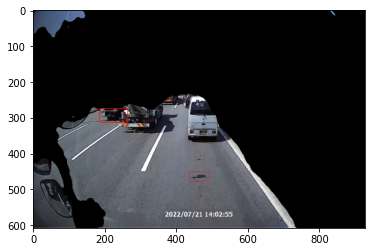

5


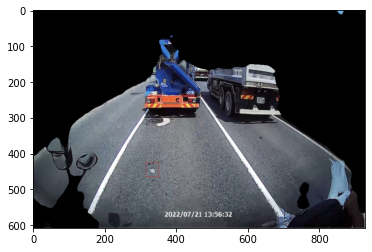

6


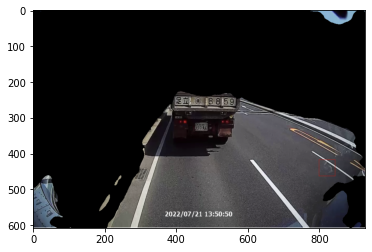

In [257]:
%matplotlib inline
import ast
for enunum, _ in enumerate(out_result_after_remove):
  print(enunum)
  img_pil = copy.deepcopy(to_yolo_imagePIL[enunum])
  for bbox in ast.literal_eval(_):
    draw = ImageDraw.Draw(img_pil)
    draw.rectangle((bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]), fill=None, outline=(255, 0, 0))
    draw.rectangle((bbox["xmin"]+1, bbox["ymin"]+1, bbox["xmax"]+1, bbox["ymax"]+1), fill=None, outline=(255, 0, 0))
  plt.figure()
  plt.imshow(img_pil)
  plt.show()
  plt.close()

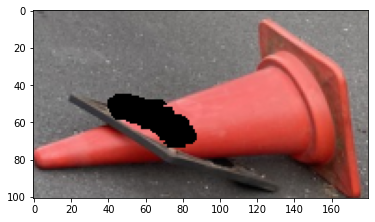

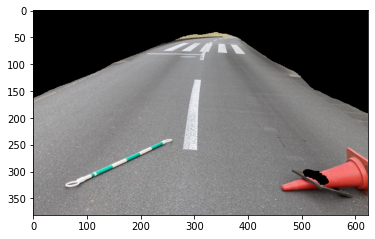

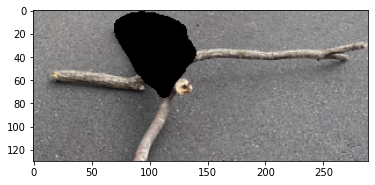

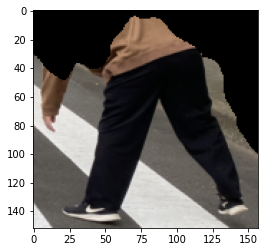

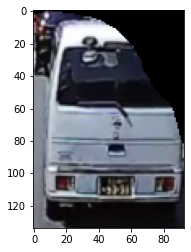

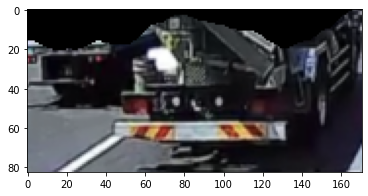

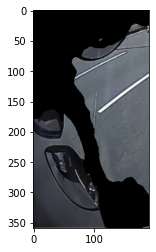

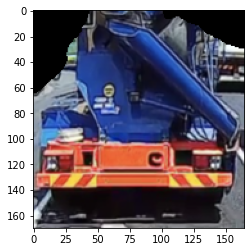

In [252]:
for i in object_images_list:
  plt.figure()
  plt.imshow(i)
  plt.show()
  plt.close()